In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
data_path = "../data-unverioned/p1c7/"
transformed_cifar10 = datasets.CIFAR10(data_path,
                                      train=True,
                                      download=True,
                                      transform= transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                          mean=(0.4915, 0.4823, 0.4468),
                                          std=(0.4915, 0.4823, 0.4468))]))

transformed_cifar10_val = datasets.CIFAR10(data_path,
                                      train=False,
                                      download=True,
                                      transform= transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize(
                                          mean=(0.4943, 0.4852, 0.4506),
                                          std=(0.2467, 0.2429, 0.2616))]))
                                      

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]

The cifar2 object satisfies the basic requirements for a Dataset—that is, __len__ and
__getitem__ are defined—so we’re going to use that.

In [4]:
len(cifar2), len(cifar2_val)

(10000, 2000)

#### A fully connected model

In [5]:
import torch.nn as nn

In [ ]:
n_out = 2

model = nn.Sequential(nn.Linear(3072, 512),
                     nn.Tanh(),
                     nn.Linear(512, n_out))
model

#### Representing the output as probabilities
Softmax is a function that takes a vector of values and produces another vector of the same dimension, where the values satisfy the constraints we just listed to represent probabilities. The expression for softmax is shown in figure.

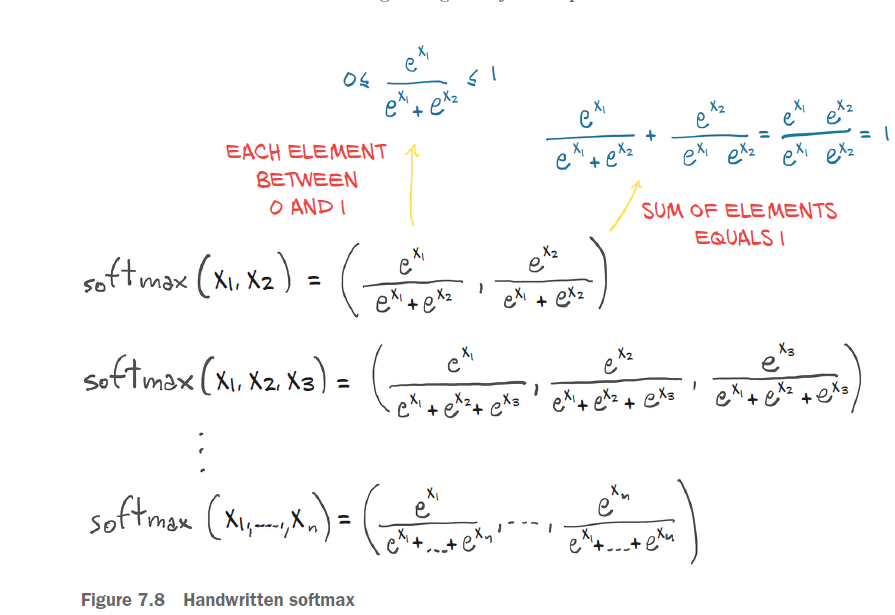

In [ ]:
model = nn.Sequential(nn.Linear(3072, 512),
                     nn.Tanh(),
                     nn.Linear(512, n_out),
                     nn.Softmax(dim=1))
model

In [ ]:
img, _ = cifar2[10]
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
# converting input images to 1D tensor
img_batch = img.view(-1).unsqueeze(0)
img_batch.shape

In [ ]:
out = model(img_batch)
out

Is the first entry “airplane” and the second “bird,” or the other way around? The network can’t even ell that at this point. It’s the loss function that associates a meaning with these two numbers, after backpropagation. If the labels are provided as index 0 for “airplane” and
index 1 for “bird,” then that’s the order the outputs will be induced to take. Thus, after training, we will be able to get the label as an index by computing the argmax of the output probabilities: that is, the index at which we get the maximum probability. Conveniently, when supplied with a dimension, torch.max returns the maximum element along that dimension as well as the index at which that value occurs.

In [ ]:
_, index = torch.max(out, dim=1)
index

In [ ]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

In [ ]:
# Then we instantiate our NLL loss:
loss = nn.NLLLoss()

In [ ]:
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

#### Defining the training loop

In [ ]:
from torch import optim
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Device:", device)

In [ ]:
n_epochs = 50

for epoch in range(1, n_epochs+1):
    avg_loss = 0.0
    for img, label in cifar2:
        img, target = img.to(device), torch.tensor([label]).to(device)
    
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss
    print("Epoch:%d, Train Loss:%.4f" %(epoch, avg_loss/len(cifar2)))

n PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. This is convenient while training RNNs. So, the default action is to accumulate (i.e. sum) the gradients on every loss.backward() call.

Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly. Else the gradient would point in some other direction than the intended direction towards the minimum (or maximum, in case of maximization objectives).

zero_grad() restarts looping without losses from the last step if you use the gradient method for decreasing the error (or losses).

If you do not use zero_grad() the loss will increase not decrease as required.

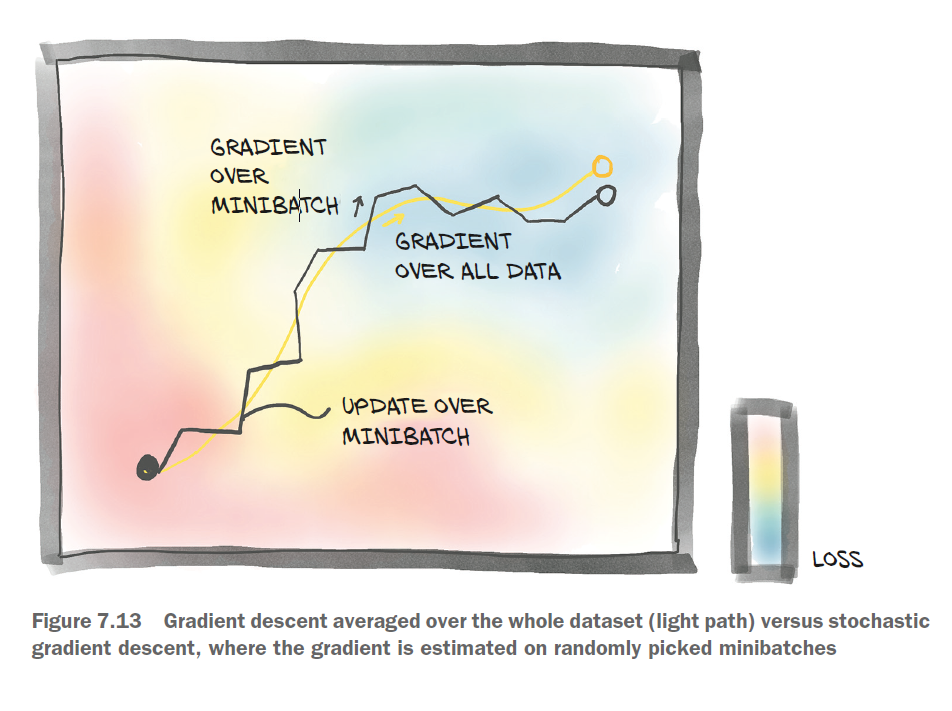

The torch.utils.data module has a class that helps with shuffling and
organizing the data in minibatches: DataLoader. The job of a data loader is to sample
minibatches from a dataset, giving us the flexibility to choose from different sampling
strategies.

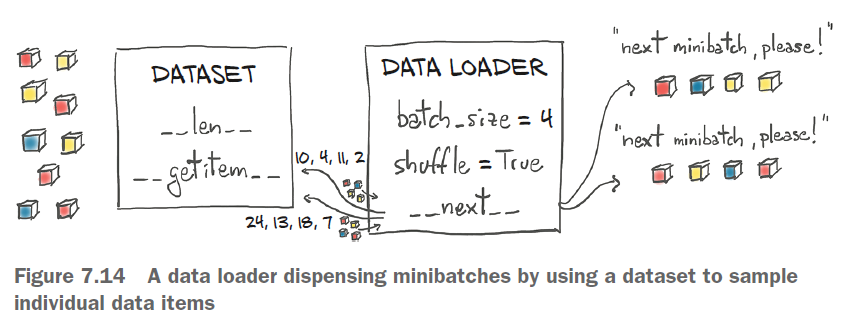

#### Using Minibatch and Dataset loader 

In [9]:
from torch import optim
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print("Device:", device)

train_loader = torch.utils.data.DataLoader(cifar2, 
                                           batch_size=64,
                                            shuffle=True)
model = nn.Sequential(
            nn.Linear(3072, 128),
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

model.to(device)

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()


Device: cuda


In [11]:
n_epochs = 100

for epoch in range(1, n_epochs+1):
    avg_loss = 0.0
    for img, label in train_loader:
        batch_size = img.shape[0]
        img, target = img.view(batch_size, -1).to(device), label.to(device)
        
        output = model(img)

        loss = loss_fn(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss
    print("Epoch:%d, Train Loss:%.4f" %(epoch, avg_loss/batch_size))

Epoch:1, Train Loss:5.4848
Epoch:2, Train Loss:4.8981
Epoch:3, Train Loss:4.7525
Epoch:4, Train Loss:4.6660
Epoch:5, Train Loss:4.6230
Epoch:6, Train Loss:4.5382
Epoch:7, Train Loss:4.4745
Epoch:8, Train Loss:4.4433
Epoch:9, Train Loss:4.3851
Epoch:10, Train Loss:4.3249
Epoch:11, Train Loss:4.2900
Epoch:12, Train Loss:4.2599
Epoch:13, Train Loss:4.2186
Epoch:14, Train Loss:4.1490
Epoch:15, Train Loss:4.1082
Epoch:16, Train Loss:4.0904
Epoch:17, Train Loss:4.0232
Epoch:18, Train Loss:3.9965
Epoch:19, Train Loss:3.9798
Epoch:20, Train Loss:3.9102
Epoch:21, Train Loss:3.8910
Epoch:22, Train Loss:3.8789
Epoch:23, Train Loss:3.8170
Epoch:24, Train Loss:3.8268
Epoch:25, Train Loss:3.7489
Epoch:26, Train Loss:3.7399
Epoch:27, Train Loss:3.6646
Epoch:28, Train Loss:3.6174
Epoch:29, Train Loss:3.5964
Epoch:30, Train Loss:3.5689
Epoch:31, Train Loss:3.5802
Epoch:32, Train Loss:3.4483
Epoch:33, Train Loss:3.4788
Epoch:34, Train Loss:3.4033
Epoch:35, Train Loss:3.3858
Epoch:36, Train Loss:3.3600
E

We can compute the accuracy of our model on the validation set in terms of the number of correct classifications over the total:

In [16]:
val_loader = torch.utils.data.DataLoader(cifar2_val,
                                         batch_size=64,
                                         shuffle=False)
correct = 0
total = 0

with torch.no_grad():
    for img, label in val_loader:
        batch_size = img.shape[0]
 
        img, target = img.view(batch_size, -1).to(device), label.to(device)
        
        output = model(img)
        _, pred = torch.max(output, dim=1)
        total += label.shape[0]
        
        correct += int((pred == target).sum())
print("Accuracy: %.4f" %(correct / total))

Accuracy: 0.7675


#### Adding more layers to model

In [10]:
from torch import optim
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print("Device:", device)


train_loader = torch.utils.data.DataLoader(cifar2, 
                                           batch_size=64,
                                            shuffle=True)

model = nn.Sequential(nn.Linear(3072, 1024),
                     nn.Tanh(),
                     nn.Linear(1024, 512),
                     nn.Tanh(),
                     nn.Linear(512, 128),
                     nn.Tanh(),
                     nn.Linear(128, 2),
                     nn.LogSoftmax(dim=1))

model.to(device)

loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

Device: cuda


PyTorch offers a quick way to determine how many parameters a model has
through the parameters() method of nn.Model (the same method we use to provide
the parameters to the optimizer). To find out how many elements are in each tensor
instance, we can call the numel method. Summing those gives us our total count.
Depending on our use case, counting parameters might require us to check whether a
parameter has requires_grad set to True, as well. We might want to differentiate the
number of trainable parameters from the overall model size. Let’s take a look at what
we have right now:

In [18]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]

sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [19]:
linear = nn.Linear(3072, 1024)
linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))